In [33]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
import sys
sys.path.append(os.path.abspath("../../../../"))
import Constants as c
import Utilities as utils
print(os.getcwd())

/Users/housemex408/Documents/Git-Projects/PRAXIS/iROIEstimator/scripts/notebook/results/FINAL/H1


In [34]:

file_line = "h1_model_performance_05_27_2020.csv"

df = pd.read_csv(file_line)

print(len(df))
# df.dropna(subset=[c.PRED_25], inplace=True)
# df.dropna(subset=[c.PRED_50], inplace=True)

# df.where(df[c.T_RECORDS] > 2, inplace = True)
# df.where(df[c.P_NA] <= .75, inplace = True)
# df.dropna()

print(len(df))

3456
3456


In [35]:
def hypothesisTest_Effort(model_records, model, task, pred, mean, sample_size):
    print("Hypothesis test for {0} and task = '{1}'".format(model, task))

    if task != "ALL":
        filter = model_records[model_records[c.TASK] == task]
        model_records = pd.concat([filter])
    
    filter = model_records[c.MODEL] == model
    model_records = model_records[filter].sample(n=sample_size, random_state=0)

    num_records = len(model_records)
    model_records_mean = round(model_records[pred].mean(),2)

    print("Number of records: {0}".format(num_records))
    print("Sample mean: ", model_records_mean)
    
    alpha = 0.05
    is_gaussian = utils.gaussian_test(model_records[pred], alpha)

    if is_gaussian:
        if num_records <= 30:
            utils.one_sample_t_test(model_records[pred], mean, alpha)
        else:
            utils.one_sample_z_test(model_records[pred], mean, alpha)
    else:
        utils.one_sample_sign_test(model_records[pred], mean, alpha)

    # model_records.boxplot(column=[pred])
    plt.figure(figsize=(8,3))
    plt.tight_layout()
    sb.distplot(model_records[pred], kde=False)

In [36]:
task = "BUG"
sample_size = 40

Hypothesis test for Module and task = 'BUG'
Number of records: 40
Sample mean:  0.73
Shapiro p-value:  0.5509713888168335
Shapiro Test: Sample looks Gaussian (fail to reject H0)
One Sample Z-test p-value:  0.9999999999999997
One Sample Z-Test: 0.73 sample mean is likely to be greater than 0.53 (fail to reject H0)


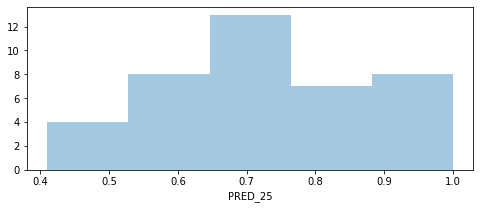

In [37]:
hypothesisTest_Effort(df.copy(), c.MODULE, task, c.PRED_25, 0.53, sample_size)

In [38]:
# hypothesisTest_Effort(df.copy(), c.MODULE, task, c.PRED_50, 0.87, sample_size)

Hypothesis test for Line and task = 'BUG'
Number of records: 40
Sample mean:  0.66
Shapiro p-value:  0.31607356667518616
Shapiro Test: Sample looks Gaussian (fail to reject H0)
One Sample Z-test p-value:  1.0
One Sample Z-Test: 0.66 sample mean is likely to be greater than 0.33 (fail to reject H0)


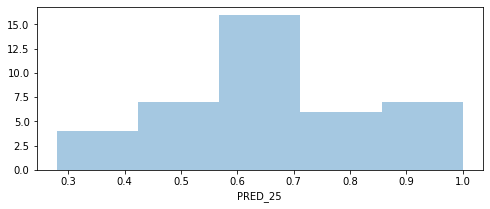

In [39]:
hypothesisTest_Effort(df.copy(), c.LINE, task, c.PRED_25, 0.33, sample_size)

In [40]:
# hypothesisTest_Effort(df.copy(), c.LINE, task, c.PRED_50, 0.60, sample_size)